In [1]:
import sys
from os.path import join, exists, abspath
from os import getcwd
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
import h5py
import seaborn as sns

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting
from nipype.interfaces import fsl

In [3]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/home/sungbeenpark/github'

In [4]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [5]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [6]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [7]:
dname = abspath(join(dir_git,'PcmPy'))
sys.path.append(dname)
import PcmPy as pcm

In [8]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import plot as splt
from SSS import image as simage

In [9]:
dir_atlas = join(dir_git,'SeqSpatialSupp_fMRI/atlas/fs_LR_32k')
border = simage.get_border(join(dir_git,'surfAnalysisPy'))

---

# GLM2

|  | trial $_{t-1}$ | trial $_{t}$ |
|---------|---------|---------|
| Both-Rep| $(i,j)$ | $(i,j)$ |
| Cue-Rep | $(i,\neg j)$ | $(i,j)$ |
| Seq-Rep | $(\neg i,j)$ | $(i,j)$ |
| NRep    | $(\neg i,\neg j)$ | $(i,j)$ |

$TS=(i,j)$

$ j=1: Letter $, $ j=2: Spatial $

$ i=1: 32451 $, $ i=2: 35124 $, $i=3: 13254 $, $ i=4: 14523$

In [10]:
glm = 2
dir_glm = su.get_dir_glm(glm)

In [11]:
subj = 'S01'

In [12]:
reginfo = deal_spm.load_reginfo(subj, glm)
reginfo

,sn,run,cond,regIdx,reg
0,1,1,1,1,B_L
1,1,1,2,2,B_S
2,1,1,3,3,C_L
3,1,1,4,4,C_S
4,1,1,5,5,N_L
...,...,...,...,...,...
59,1,8,4,60,C_S
60,1,8,5,61,N_L
61,1,8,6,62,N_S
62,1,8,7,63,S_L


---

## Design Matrix

In [13]:
SPM = join(dir_glm, subj, 'SPM.mat')

X = deal_spm.get_SPM_X(SPM, run=1)
X.shape

(407, 8)

[Text(0.5, 0, 'B_L'),
 Text(1.5, 0, 'B_S'),
 Text(2.5, 0, 'C_L'),
 Text(3.5, 0, 'C_S'),
 Text(4.5, 0, 'N_L'),
 Text(5.5, 0, 'N_S'),
 Text(6.5, 0, 'S_L'),
 Text(7.5, 0, 'S_S')]

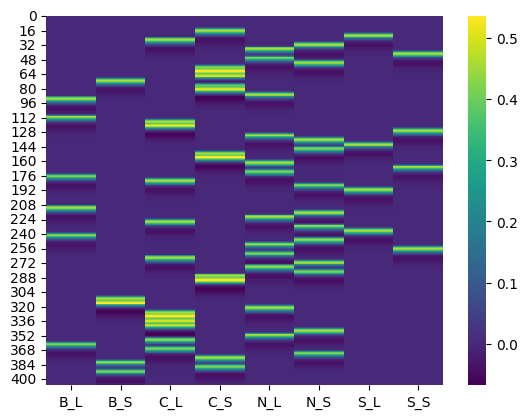

In [14]:
g = sns.heatmap(X, cmap=cm.viridis)
g.set_xticklabels(reginfo[reginfo.run==1].reg)

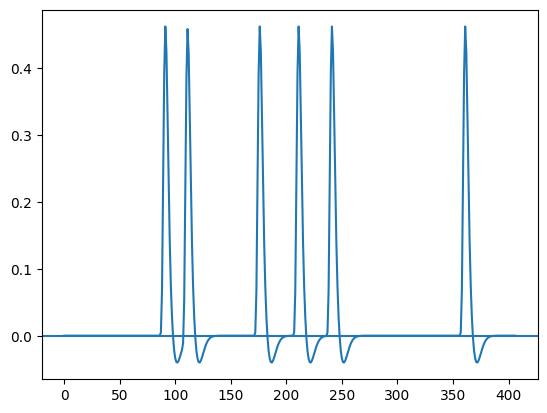

In [15]:
y = X[:,0]
plt.plot(y)
plt.axhline(y=np.median(y))

In [16]:
SPM = join(dir_glm, subj,'SPM.mat')

df = deal_spm.get_df_X(SPM)
df

,TR,run,X_sum
0,0,1,0.000000
1,1,1,0.000000
2,2,1,0.000000
3,3,1,0.000000
4,4,1,0.000000
...,...,...,...
3251,402,8,-0.058913
3252,403,8,-0.050791
3253,404,8,-0.041897
3254,405,8,-0.033227


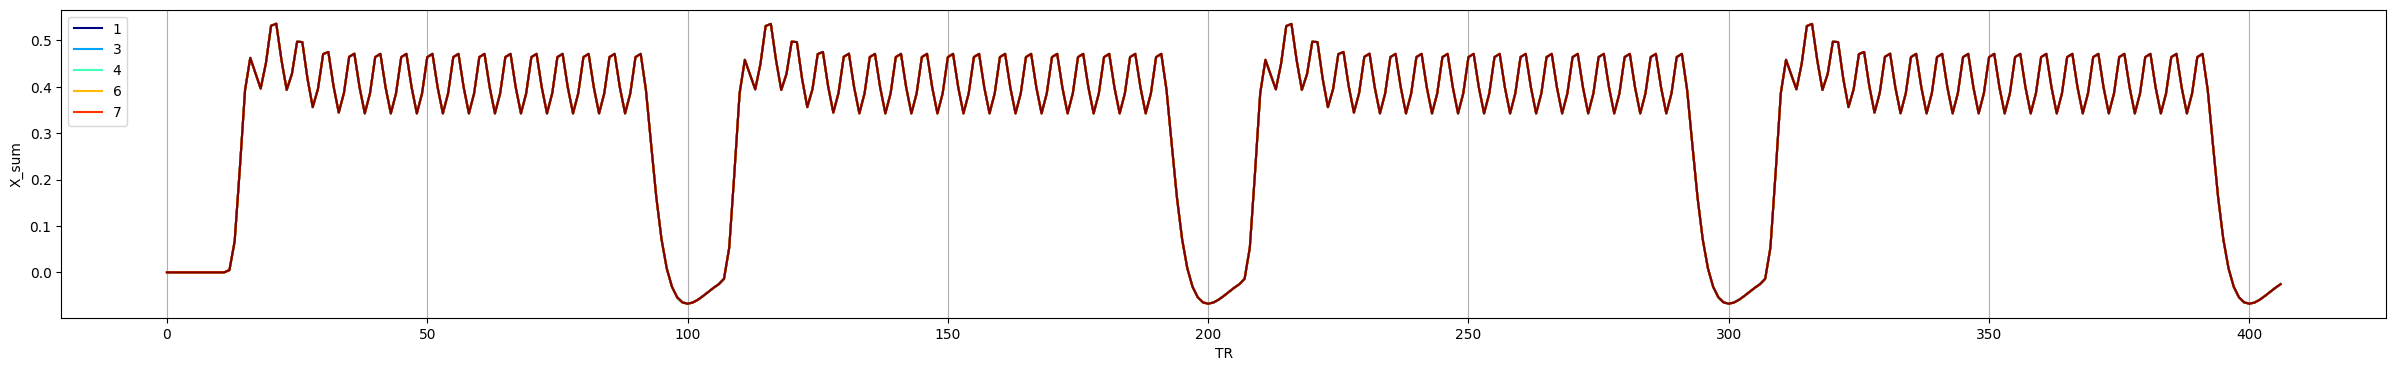

In [17]:
fig, ax = plt.subplots(figsize=(30,4))

g = sns.lineplot(
    data=df,
    x='TR', y='X_sum', hue='run',
    palette=cm.jet.resampled(8),
    ax=ax
)
g.grid(axis='x')
g.legend(loc='upper left')

---

## Contrast

$$RDM = \begin{bmatrix}
\textcolor{gray}{B} & C & C & C & S & N & N & N \\
C & \textcolor{gray}{B} & C & C & N & S & N & N \\
C & C & \textcolor{gray}{B} & C & N & N & S & N \\
C & C & C & \textcolor{gray}{B} & N & N & N & S \\
S & N & N & N & \textcolor{gray}{B} & C & C & C \\
N & S & N & N & C & \textcolor{gray}{B} & C & C \\
N & N & S & N & C & C & \textcolor{gray}{B} & C \\
N & N & N & S & C & C & C & \textcolor{gray}{B}
\end{bmatrix}$$
The number of elements on the upper triangle $= \frac{8\cdot 7}{2} = 28$
1. B: both of cue and sequence repetition (8 trials)
2. S: only sequence repetition (8 trials)
3. C: only cue repetition (24 trials)
4. N: no repetition (24 trials)

In [18]:
dir_surf = su.get_dir_surf()
hemi = 'L'

In [19]:
dir_work = join(dir_surf,'glm_%d'%glm)

- Conditions:
    1. BothRep_L (B)
    2. BothRep_S (B)
    3. CueRep_L (C)
    4. CueRep_S (C)
    5. NonRep_L (N)
    6. NonRep_S (N)
    7. SeqRep_L (S)
    8. SeqRep_S (S)

- Contrasts:
    1. BothRep_L:  $c=[1\ 0\ 0\ 0\ 0\ 0\ 0\ 0]$
    2. BothRep_S:  $c=[0\ 1\ 0\ 0\ 0\ 0\ 0\ 0]$
    3. CueRep_L:   $c=[0\ 0\ 1\ 0\ 0\ 0\ 0\ 0]$
    4. CueRep_S:   $c=[0\ 0\ 0\ 1\ 0\ 0\ 0\ 0]$
    5. NonRep_L:   $c=[0\ 0\ 0\ 0\ 1\ 0\ 0\ 0]$
    6. NonRep_S:   $c=[0\ 0\ 0\ 0\ 0\ 1\ 0\ 0]$
    7. SeqRep_L:   $c=[0\ 0\ 0\ 0\ 0\ 0\ 1\ 0]$
    8. SeqRep_S:   $c=[0\ 0\ 0\ 0\ 0\ 0\ 0\ 1]$
    9. wRS_L:      $c=[1\ 0\ \!-\!1\ 0\ 0\ 0\ 0\ 0]$
    10. wRS_S:     $c=[0\ 1\ 0\ \!-\!1\ 0\ 0\ 0\ 0]$
    11. wRS_L-S:   $c=$ wRS_L - wRS_S
    12. acRS_L:    $c=[0\ 0\ 0\ 0\ \!-\!1\ 0\ 1\ 0]$
    13. acRS_S:    $c=[0\ 0\ 0\ 0\ 0\ \!-\!1\ 0\ 1]$
    14. acRS-L-S:  $c=$ acRS_L - acRS_S
    15. Letter:    $c=[1\ 0\ 1\ 0\ 1\ 0\ 1\ 0\ 0]*0.25$
    16. Spatial:   $c=[0\ 1\ 0\ 1\ 0\ 1\ 0\ 1\ 0]*0.25$
    17. L-S:       $c=[1\ \!-\!1\ 1\ \!-\!1\ 1\ \!-\!1\ 1\ \!-\!1\ 0]$

- Calculation:
    $$ \vec{c}\cdot\vec{\beta}=d $$

In [20]:
fnames = glob(join(dir_work,'???.%s.glm_%d.t.func.gii'%(hemi,glm)))
len(fnames)

24

In [21]:
alpha = 0.05
thresh = scipy.stats.t.ppf(1-0.5*alpha,df=len(fnames)-1)
print(thresh)

2.0686576104190406


In [22]:
orders = simage.load_contrast_order(subj,glm,map='t')
orders

array(['spmT_B_L.nii', 'spmT_B_S.nii', 'spmT_C_L.nii', 'spmT_C_S.nii',
       'spmT_Letter-Spatial.nii', 'spmT_Letter.nii', 'spmT_N_L.nii',
       'spmT_N_S.nii', 'spmT_S_L.nii', 'spmT_S_S.nii', 'spmT_Spatial.nii',
       'spmT_acRS_L-S.nii', 'spmT_acRS_L.nii', 'spmT_acRS_S.nii',
       'spmT_wRS_L-S.nii', 'spmT_wRS_L.nii', 'spmT_wRS_S.nii'],
      dtype='<U23')

### i) Task-related activity

In [26]:
vmin, vmax = -10, 10

In [27]:
idxs = [5, 10, 4]

spmT_Letter.nii
spmT_Spatial.nii
spmT_Letter-Spatial.nii


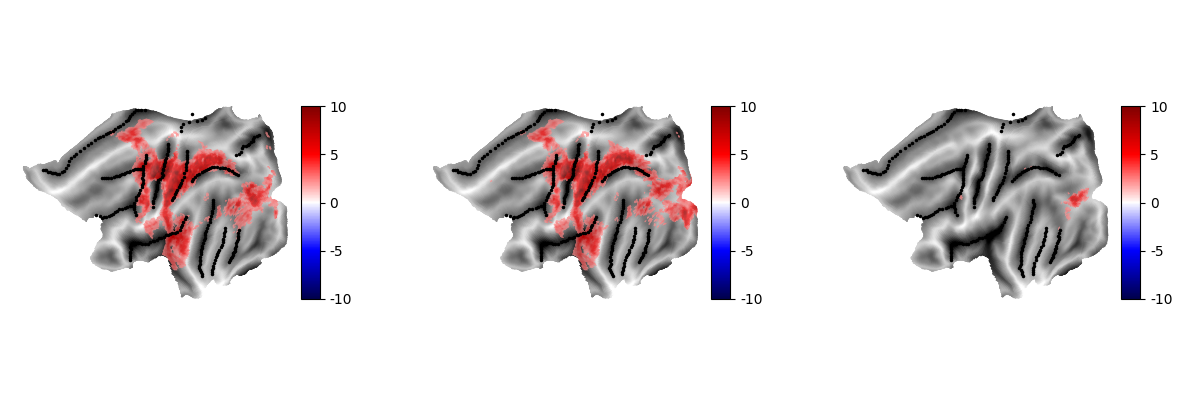

In [28]:
ncols = len(idxs)
fig, axs = plt.subplots(ncols=ncols, figsize=(5*ncols,5))

for ii, idx in enumerate(idxs):
    ax = axs[ii]
    plt.sca(ax)
    
    cond = orders[idx]
    print(cond)

    dataset = []
    for fname in fnames:
        gii = nb.load(fname)
        data = gii.darrays[idx].data
        dataset.append(data)
    dataset = np.array(dataset)
    
    g = surf.plot.plotmap(
        data=dataset.mean(axis=0),
        surf='fs32k_%s'%hemi,
        alpha=0.7,
        cmap=cm.seismic, colorbar=True, cscale=[vmin,vmax],
        threshold=thresh,
        borders=border, bordercolor='black', bordersize=3,
        overlay_type='func', render='matplotlib'
    )

### ii)

In [38]:
vmin, vmax = -2, 2

In [39]:
idxs = [15, 16, 14]

spmT_wRS_L.nii
spmT_wRS_S.nii
spmT_wRS_L-S.nii


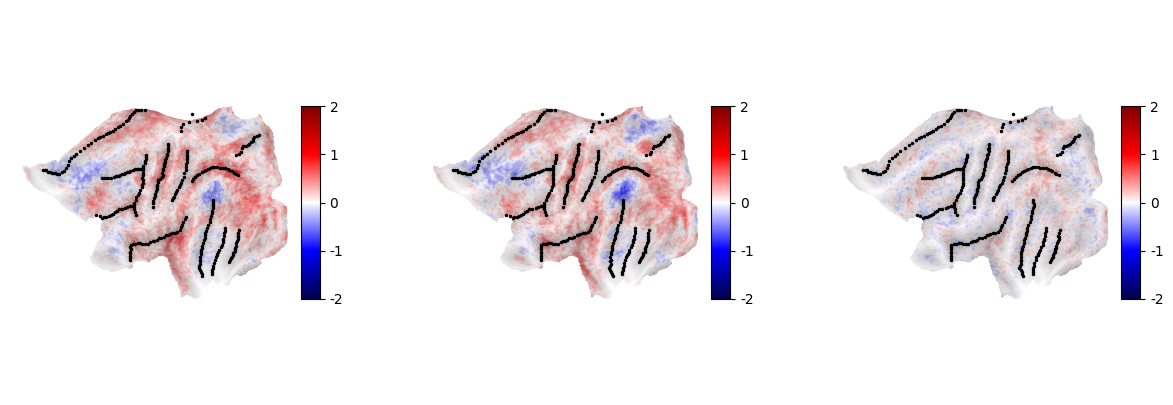

In [40]:
ncols = len(idxs)
fig, axs = plt.subplots(ncols=ncols, figsize=(5*ncols,5))

for ii, idx in enumerate(idxs):
    ax = axs[ii]
    plt.sca(ax)
    
    cond = orders[idx]
    print(cond)

    dataset = []
    for fname in fnames:
        gii = nb.load(fname)
        data = gii.darrays[idx].data
        dataset.append(data)
    dataset = np.array(dataset)
    
    g = surf.plot.plotmap(
        data=dataset.mean(axis=0),
        surf='fs32k_%s'%hemi,
        alpha=0.7,
        cmap=cm.seismic, colorbar=True, cscale=[vmin,vmax],
        # threshold=thresh,
        borders=border, bordercolor='black', bordersize=3,
        overlay_type='func', render='matplotlib'
    )

### iii)

In [41]:
vmin, vmax = -2, 2

In [42]:
idxs = [12, 13, 11]

spmT_acRS_L.nii
spmT_acRS_S.nii
spmT_acRS_L-S.nii


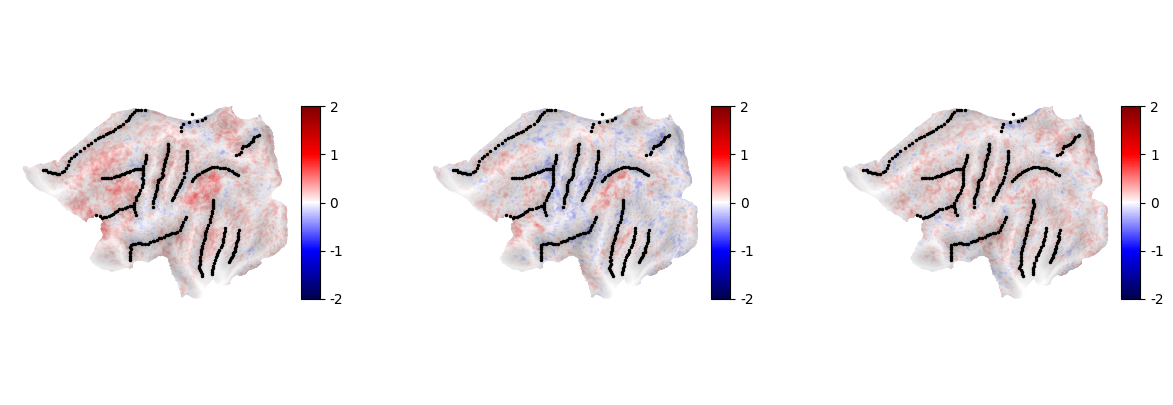

In [43]:
ncols = len(idxs)
fig, axs = plt.subplots(ncols=ncols, figsize=(5*ncols,5))

for ii, idx in enumerate(idxs):
    ax = axs[ii]
    plt.sca(ax)
    
    cond = orders[idx]
    print(cond)

    dataset = []
    for fname in fnames:
        gii = nb.load(fname)
        data = gii.darrays[idx].data
        dataset.append(data)
    dataset = np.array(dataset)
    
    g = surf.plot.plotmap(
        data=dataset.mean(axis=0),
        surf='fs32k_%s'%hemi,
        alpha=0.7,
        cmap=cm.seismic, colorbar=True, cscale=[vmin,vmax],
        # threshold=thresh,
        borders=border, bordercolor='black', bordersize=3,
        overlay_type='func', render='matplotlib'
    )

---

## Percent Signal Change

---